# HoxHunt Summer Hunters 2020 - Data - Home assignment


<img src="https://www.dropbox.com/s/zmuij2fyjo27j1u/Screenshot%202019-03-21%2017.28.10.png?dl=1" width="1000">

## Assignment

In this assignment you as a HoxHunt Data Science Hunter are given the task to extract interesting features from a possible malicious indicator of compromise, more specifically in this case from a given potentially malicious URL. 

<img src="https://www.dropbox.com/s/ao0neaphtfama7g/Screenshot%202019-03-21%2017.23.40.png?dl=1" width="400">

This assignment assumes that you are comfortable (or quick to learn) on using Jupyter Notebooks and suitable programming enviroment such as Python, R or Julia. The example below uses Python and has some external dependencies such as Requests library.

Happy hunting!


## Interesting research papers & resources

Below is a list of interesting research papers on the topic. They might give you good tips what features you could extract from a given URL:


[Know Your Phish: Novel Techniques for Detecting
Phishing Sites and their Targets](https://arxiv.org/pdf/1510.06501.pdf)

[DeltaPhish: Detecting Phishing Webpages
in Compromised Websites](https://arxiv.org/pdf/1707.00317.pdf)

[PhishAri: Automatic Realtime Phishing Detection on Twitter](https://arxiv.org/pdf/1301.6899.pdf)

[More or Less? Predict the Social Influence of Malicious URLs on Social Media
](https://arxiv.org/abs/1812.02978)

[awesome-threat-intelligence](https://github.com/hslatman/awesome-threat-intelligence)



## What we expect

Investigate potential features you could extract from the given URL and implement extractors for the ones that interest you the most. Below example code extracts one feature but does not store it very efficiently (just console logs it). Implement sensible data structure using some known data structure library to store the features per URL. Also consider how would you approach error handling if one feature extractor fails?

Be prepared to discuss questions such as: what features could indicate the malicousness of a given URL? What goes in to the thinking of the attacker when they are choosing a site for an attack? What would you develop next?

## What we don't expect

Implement a humangous set of features.

Implement any kind of actual predicition models that uses the features to give predictions on malicousness at this stage :) 

## My first thoughts


Feature engineering is very much about creativity, hence I think it is very valuable when starting to work on a new problem to first try creating features on your own for a few days before diving into other people's approaches or papers. I think seeing how other people have solved a problem before very much steers your thinking into that direction unconsiously. 


## Journal
    - 21.02 Read the problem, understand what its about and start generating features relying solely on own experience and intuition.

    - 23.02 Start reading papers for more ideas. Implement Random forests for the academic phising dataset.
    
    - 24.02 Generate more features.


In [288]:
import requests
import json
import pandas as pd
from urllib.parse import urlparse

def get_domain_age_in_days(domain):
    show =  "https://input.payapi.io/v1/api/fraud/domain/age/" + domain
    try:
        r = requests.get(show)
        r.raise_for_status()
        data = r.json()
        return data['result'] if 'result' in data else None
    except requests.exceptions.RequestException as e:  
        return str(e).split(':')[0]
    
# https://ip-api.com/ is a free geolocation API
def get_hosting_country(domain):
    show = "http://ip-api.com/json/" + domain
    try:
        r = requests.get(show)
        r.raise_for_status()
        data = r.json()
        return data['country'] if data['status'] == 'success' else data['message']
    except requests.exceptions.RequestException as e:  
        return str(e).split(':')[0]
    
def get_org_field(domain):
    show = "http://ip-api.com/json/" + domain
    try:
        r = requests.get(show)
        r.raise_for_status()
        data = r.json()
        return data['org'] if data['status'] == 'success' else data['message']
    except requests.exceptions.RequestException as e:  
        return str(e).split(':')[0]
    
def parse_domain_from_url(url):
    t = urlparse(url).netloc
    return '.'.join(t.split('.')[-2:])

def remove_prefix(text, prefix):
    return text[len(prefix):] if text.startswith(prefix) else text

def clean_up_url(url):
    prefixes = ['http://', 'https://']
    for prefix in prefixes:
        url = remove_prefix(url, prefix)
    return url

def analyze_url(url, api=True):
    
    # Dictionaries are extremely efficient and optimized in python. Also easy to chuck into a database.
    features = dict()
    # First feature, if domain is new it could indicate that the bad guy has bought it recently...
    domain = parse_domain_from_url(url)
    
    if api:
        features['domain_hosting_country'] = get_hosting_country(domain)
        features['domain_org_field'] = get_org_field(domain)
        features['domain_age_in_days'] = get_domain_age_in_days(domain);
    
    # Basic features
    features['url'] = url
    features['url_length'] = len(url)
    features['n_numbers_in_url'] = sum(c.isdigit() for c in url)
    features['n_dots_in_url'] = url.count('.')
    features['https_url'] = url[:5] == 'https'
    
    ## Remove http, https
    features['url'] = clean_up_url(features['url'])
    features['begins_with_www'] = features['url'].startswith('www.')
    
    ## Remove www.
    features['url'] = remove_prefix(features['url'], 'www.')
    
    return features

In [289]:
# Note some of these urls are live phishing sites (as of 2019-03-21) use with caution! More can be found at https://www.phishtank.com/
example_urls = ["https://www.slideshare.net/weaveworks/client-side-monitoring-with-prometheus",
                "http://cartaobndes.gov.br.cv31792.tmweb.ru/",
                "https://paypal.co.uk.yatn.eu/m/",
                "http://college-eisk.ru/cli/",
                "https://dotpay-platnosc3.eu/dotpay/",
                "https://www.facebook.com/",
                "https://www.nettiauto.com/"
               ]


## Problem with features that require requests

One problem I had not thought about before this assignment is the problem of API queried features. 

When generating features for large dataframes, querying API:s or doing GET request to get page content will slow down the calculations too much.

This will result in the fact that queried features would have to be generated online when data is being collected. This makes it hard to leverage Open data that has already been collected by other people. Which is the case in phising urls aswell.

I guess it can also solved with huge amount of computational resources, but that's practical for only Google and Facebook.

In the following I will demonstrate the time difference between computing the API features compared to non API features.

### Timing with API calls




In [290]:
%%time
# Initialize the DF with the first item
url_iter = iter(example_urls)
features = analyze_url(next(url_iter))
df = pd.DataFrame([list(features.values())], columns=list(features.keys()))

for url in url_iter: 
    features = analyze_url(url)
    df = df.append(pd.DataFrame([list(features.values())], columns=list(features.keys())), ignore_index=True)
    

CPU times: user 373 ms, sys: 12.1 ms, total: 385 ms
Wall time: 3.13 s


### Timing without API calls

In [291]:
%%time
# Initialize the DF with the first item
url_iter = iter(example_urls)
features = analyze_url(next(url_iter), api=False)
df = pd.DataFrame([list(features.values())], columns=list(features.keys()))
for url in url_iter: 
    features = analyze_url(url, api=False)
    df = df.append(pd.DataFrame([list(features.values())], columns=list(features.keys())), ignore_index=True)

CPU times: user 12.4 ms, sys: 3.95 ms, total: 16.4 ms
Wall time: 16.4 ms


In [292]:
3.47 / 0.0176

197.1590909090909

197 times faster without querying API:s


This would be too slow for any reasonable size dataset.

This also shows the power offline features that are just based on the URL string not the page content or other factors. These types of features can be computed drastically faster than features that need to make requests to API:s or even GET the page content.

## Extra activities

I think one of the most important things to do in the beginning of a new ML problem is to get a basic pipeline rolling as soon as possible and test some basic models. This gives you a valuable baseline model that you can compare your other models against. Also you should get some basic model to production as soon as possible to see if your users even like the feature. This allows you to see all sorts of problems and they're easier to solve before the models/infra gets too complex.

I loaded the Aalto phish storm dataset and decided to try random forest to get some idea, which type of features would work.

Dataset: https://research.aalto.fi/en/datasets/phishstorm--phishing--legitimate-url-dataset(f49465b2-c68a-4182-9171-075f0ed797d5).html

In [83]:
import re
import tldextract as tlde
import warnings
warnings.filterwarnings('ignore') # Added after we are done to suppress useless warnings.
from string import punctuation

In [6]:
data = pd.read_csv('data/urlset.csv', encoding='latin', error_bad_lines=False)
data = data[['domain', 'label']]

b'Skipping line 18259: expected 14 fields, saw 15\nSkipping line 18273: expected 14 fields, saw 15\n'


In [252]:
def shortened_url(url):
    # From: https://www.adweek.com/digital/top-5-url-shorteners-and-3-honorable-mentions/
    common = ['bit.ly', 'goo.gl', 'Owl.ly', 'Deck.ly', 'Su.pr',
              'fur.ly', 'moourl.com']
    return any(x in url for x in common)




def split_url(row):
    splitted = re.split('[^a-zA-Z]', row['domain'])
    splitted = [x for x in splitted if x != ""]
    try:
        splitted.remove(row['ps'])
        splitted.remove(row['mld'])
    except ValueError:
        pass
    
    return splitted

def n_non_alphanumerics(string):
    return len([char for char in string if not char.isalpha()])


#https://www.researchgate.net/publication/333166694_Phishing_URL_detection_system_based_on_URL_features_using_SVM
def n_suspicous_chars(string):
    return len([char for char in string if char in punctuation])


# https://www.wandera.com/top-10-mobile-phishing-techniques/
def top_misspelled(domain):
    top_misspelled = ['apple-com', 'applecom', 'apple.con', 'appie.com',  'app-le.com',
                      'pavpal.com', 'puaypal.com', 'pauypal.com', 'paypal-com', 'paypai.com',
                      'wellsf.argo.com', 'Iclod.com', 'icloud-com', '1cloud.com', 'lcloud.com',
                      'apple-id', 'apple.id', 'appleld', 'appieid', 'applid',
                      'facbook', 'ficebook', 'faceboook', 'facebo0k', 'faceebook',
                     'amazo', 'amazn', 'a-mazon', 'amzon', 'microsft', 'gooogle', 'gogle',
                     'americaexpress']
    return any(misspelled in domain for misspelled in top_misspelled)

def top_companies(domain):
    companies = ['apple', 'microsoft', 'paypal', 'amazon', 'facebook',
                 'americanexpress', 'apple-id', 'icloud']
    
    return any(company in domain for company in companies)

# Redirection happens with double //
def redirection(domain):
   # NOTE: Assumes that the domain is cleaned meaning no https:// in the beginning 
    return '//' in domain

# left side of @ sign is not considered
def at_sign(domain):
    return '@' in domain

def question_mark(domain):
    return '?' in domain    

def www_in_middle(domain):
    keywords = ['http', 'https', 'www']
    return any(kw in domain for kw in keywords)

def extract_domain_parts(data):
    data['domain'] = data['domain'].apply(clean_up_url)
    data['ps'] = data['domain'].apply(lambda x: tlde.extract(x).suffix)
    data['mld'] = data['domain'].apply(lambda x: tlde.extract(x).domain)
    data['mld.ps'] = data['domain'].apply(lambda x: tlde.extract(x).domain + '.' + tlde.extract(x).suffix)
    data['sld'] = data['domain'].apply(lambda x: tlde.extract(x).subdomain)
    data['rem'] = data.apply(split_url, axis=1)
    return data


def create_features(data):
    data['url_length'] = data['domain'].apply(len)
    data['n_numbers_in_url'] = data['domain'].apply(lambda url: sum(c.isdigit() for c in url))
    data['n_dots_in_url'] = data['domain'].apply(lambda url: url.count('.'))
    data['n_dashes_in_url'] = data['domain'].apply(lambda url: url.count('-'))
    data['shortened_url'] = data['domain'].apply(shortened_url)
    data['n_subdomains'] = data['rem'].apply(len)
    data['n_non_alphanumerics'] = data['domain'].apply(n_non_alphanumerics)
    data['n_suspicious'] = data['domain'].apply(n_suspicous_chars)
    data['misspelled'] = data['domain'].apply(top_misspelled)
    data['popular_companies'] = data['domain'].apply(top_companies)
    data['redirection'] = data['domain'].apply(redirection)
    data['at_sign'] = data['domain'].apply(at_sign)
    data['question_mark'] = data['domain'].apply(question_mark)
    data['www_in_middle'] = data['domain'].apply(www_in_middle)
    
    return data



In [66]:
data = extract_domain_parts(data)

### Dataset of page ranked urls

Dataset: https://www.domcop.com/top-10-million-domains

This dataset contains the top 10 million domains based on google's page rank algorithm.

The assumption is that phising url most likely won't appear in this list.

https://www.domcop.com/openpagerank/what-is-openpagerank


In [16]:
most_common_domains = pd.read_csv('data/top10milliondomains.csv')

### Precomputed dictionary

We have a 10 million element list of common domains based on their page rank.

Since we want to generate features on whether a domain in our dataset is contained in that 10 million elements we need to search operations.

Precomputing a Hash Map (Python dict) that contains the domain as key and the ranking of the page as value makes this search million times faster as for hash maps search is O(1) and for lists O(N).

In [12]:
ranking_dict = {}
def page_ranking(row):
        return ranking_dict[row['mld.ps']] if row['in_10mil_most_common'] else -1
    
def common_page(domain):
    return domain in ranking_dict
    
def make_ranking_dict(row):
    ranking_dict[row['Domain']] = row['Open Page Rank']

In [24]:
%%time 
_ = most_common_domains.apply(make_ranking_dict, axis=1)

CPU times: user 4min 21s, sys: 1.11 s, total: 4min 22s
Wall time: 4min 23s


4 minutes to create dict of 10 million elements not too bad.

I still prefer to not do this again, hence let's store the dict as a pickle file for fast reloading.

In [25]:
# Store the dict as a pickle.
import pickle
with open('data/ranking.pickle', 'wb') as handle:
    pickle.dump(ranking_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [27]:
# Load the dict from the pickle file
with open('data/ranking.pickle', 'rb') as handle:
    ranking_dict = pickle.load(handle)

In [256]:
ranking_dict

{'fonts.googleapis.com': 10.0,
 'facebook.com': 10.0,
 'twitter.com': 10.0,
 'youtube.com': 10.0,
 'google.com': 10.0,
 's.w.org': 10.0,
 'instagram.com': 10.0,
 'googletagmanager.com': 10.0,
 'linkedin.com': 10.0,
 'ajax.googleapis.com': 10.0,
 'gmpg.org': 10.0,
 'plus.google.com': 9.78,
 'pinterest.com': 9.52,
 'wordpress.org': 9.11,
 'maps.google.com': 9.04,
 'en.wikipedia.org': 8.92,
 'goo.gl': 8.84,
 'youtu.be': 8.82,
 'play.google.com': 8.82,
 'support.google.com': 8.81,
 'amazon.com': 8.71,
 'itunes.apple.com': 8.67,
 'github.com': 8.56,
 'maps.googleapis.com': 8.55,
 'bit.ly': 8.53,
 'vimeo.com': 8.5,
 'docs.google.com': 8.48,
 'developers.google.com': 8.45,
 'drive.google.com': 8.43,
 's3.amazonaws.com': 8.41,
 'fonts.gstatic.com': 8.39,
 'wordpress.com': 8.39,
 'cdnjs.cloudflare.com': 8.37,
 'creativecommons.org': 8.34,
 'reddit.com': 8.33,
 'google-analytics.com': 8.28,
 'medium.com': 8.27,
 'vk.com': 8.26,
 'lh3.googleusercontent.com': 8.25,
 'm.facebook.com': 8.23,
 'i.img

In [34]:
# Back of the envelope calculation
%time test = data['mld.ps'][:10000].apply(common_page)

CPU times: user 9.21 ms, sys: 26 µs, total: 9.24 ms
Wall time: 9.24 ms


In [35]:
len(data) / 10000 * 0.009

0.0864045

The Computation should take roughly 80ms. 

Quite an improvement as without the dict it was taking 50 minutes.

In [36]:
%%time
data['in_10mil_most_common'] = data['mld.ps'].apply(common_page)

CPU times: user 45.6 ms, sys: 34 µs, total: 45.6 ms
Wall time: 45.7 ms


In [38]:
%%time 
data['page_ranking'] = data.apply(page_ranking, axis=1)

CPU times: user 2.1 s, sys: 43.7 ms, total: 2.15 s
Wall time: 2.17 s


In [235]:
final_data = create_features(data)

In [236]:
final_data.to_pickle('data/final.pickle')

Store the final feature engineered dataframe as pickle for fast reload.

In [237]:
final_data = pd.read_pickle('data/final.pickle')

In [238]:
final_data = final_data.drop(['ps', 'mld', 'mld.ps', 'sld', 'rem'], axis=1)

In [239]:
final_data.isnull().sum(axis=0)

domain                   0
label                   92
in_10mil_most_common     0
page_ranking             0
url_length               0
n_numbers_in_url         0
n_dots_in_url            0
shortened_url            0
n_subdomains             0
n_non_alphanumerics      0
n_suspicious             0
misspelled               0
popular_companies        0
n_dashes_in_url          0
redirection              0
at_sign                  0
question_mark            0
www_in_middle            0
company_legit_url        0
dtype: int64

Some label columns are null, hence we should drop them.

In [240]:
final_data = final_data.dropna(subset=['label'])

### Random forests

Random forests is always my first go to algorithm for tabular data problems.

It works well most of the time with very little parameter tuning.

Even for problems where a more complex model is needed, I still start with Random Forests as it provides a nice model to benchmark the performance of other models to.


In [241]:
y = final_data['label']
X = final_data.drop(['label', 'domain'], axis=1)

In [242]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [243]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, random_state=42)

In [244]:
m = RandomForestClassifier(n_estimators=500, max_features='log2', random_state=42,
                           min_samples_leaf=1, n_jobs=-1);

In [246]:
m.fit(X_train, y_train);

### Interpretability of Random Forests

One of the best features of Random Forests is that it provides you with feature importance.

This tells us, which features were most influental in making the prediction. Which can be key in some applications that require reasons for the predictions.

In [247]:
def rf_feature_importance(df, m):
    df = pd.DataFrame({'cols' : df.columns, 'imp' : m.feature_importances_}).sort_values('imp', ascending=False)
    return df

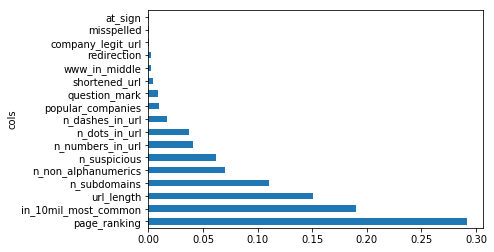

In [248]:
fi = rf_feature_importance(X_train, m)
fi.plot('cols', 'imp', kind='barh', legend=False);

In [249]:
y_pred = m.predict(X_valid)

In [250]:
from sklearn.metrics import accuracy_score

In [251]:
accuracy_score(y_valid, y_pred)

0.9309048401364842

93% accuracy pretty nice!

In the paper they achieved 94.91% accuracy with very complex feature engineering, granted we are not using the same validation set, so the results are not completely comparable.

### Analyze missclassified instances

Analyzing the domain names of missclassified instances can give us ideas for new features

In [223]:
missclassified = X_valid[y_pred != y_valid].index

In [229]:
missed = final_data.iloc[missclassified]

In [232]:
missed[missed['label'] == 1.0]

,domain,label,in_10mil_most_common,page_ranking,url_length,n_numbers_in_url,n_dots_in_url,shortened_url,n_subdomains,n_non_alphanumerics,n_suspicious,misspelled,popular_companies,n_dashes_in_url,redirection,at_sign,question_mark,www_in_middle
43141,thelivewirenews.com/Sql/Site/Atualizacao/Onlin...,1.0,False,-1.00,78,0,2,0,8,9,9,False,False,0,False,False,False,False
8341,ainotap.com/wp-includes/css/,1.0,False,-1.00,28,0,1,0,3,5,5,False,False,1,False,False,False,False
5671,livechat26.volusion.com/livechat.aspx?ID=11805...,1.0,True,4.99,134,20,3,0,15,39,19,False,False,1,False,False,True,False
4731,ppf.udsu.ru/english/language/itau.atualizar/,1.0,True,3.79,44,0,3,0,5,7,7,False,False,0,False,False,False,False
36790,paypal.com.ca.cgi.bin.webscr.cmd.flow.help.wld...,1.0,False,-1.00,222,50,15,0,37,69,19,False,True,0,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11464,www4049u.sakura.ne.jp/index.htm,1.0,True,4.36,31,4,4,0,7,9,5,False,False,0,False,False,False,True
23094,arrowlighthaulage.co.uk/arrowblog/wp-content/u...,1.0,True,3.27,75,6,4,0,10,17,11,False,False,1,False,False,False,False
43863,paypal-germany.de/11953/index.php,1.0,False,-1.00,33,5,2,0,4,10,5,False,True,1,False,False,False,False
5325,buyeobae.com/flash/go.php,1.0,False,-1.00,25,0,2,0,3,4,4,False,False,0,False,False,False,False


These instances were falsely classified as non phising urls.

In [233]:
missed[missed['label'] == 0.0]

,domain,label,in_10mil_most_common,page_ranking,url_length,n_numbers_in_url,n_dots_in_url,shortened_url,n_subdomains,n_non_alphanumerics,n_suspicious,misspelled,popular_companies,n_dashes_in_url,redirection,at_sign,question_mark,www_in_middle
65483,bravenewcode.com/store/plugins/wptouch-pro/,0.0,True,4.77,43,0,1,0,4,6,6,False,False,1,False,False,False,False
48012,kpmg.com/pk/en/,0.0,True,5.13,15,0,1,0,2,4,4,False,False,0,False,False,False,False
52292,mbendi.com/WEC/index.htm,0.0,True,4.59,24,0,2,0,3,4,4,False,False,0,False,False,False,False
61411,altova.com/authentic.html,0.0,True,4.65,25,0,2,0,2,3,3,False,False,0,False,False,False,False
48358,personal.smartt.com/~brianp,0.0,True,3.69,27,0,2,0,2,4,4,False,False,0,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89794,webring.com/hub?ring=wiznetsitering,0.0,True,4.49,35,0,1,0,3,4,4,False,False,0,False,False,True,False
91357,mysite.verizon.net/~vze4r2c2/Diplomacy/,0.0,True,4.39,39,3,2,0,5,9,6,False,False,0,False,False,False,False
49336,freewebs.com/cp-enterprises/,0.0,True,6.81,28,0,1,0,2,4,4,False,False,1,False,False,False,False
52767,cargill.com/food/,0.0,True,4.96,17,0,1,0,1,3,3,False,False,0,False,False,False,False


These instances were falsely classified as phising urls

## Implementing the paper
PhishStorm: Detecting Phishing with Streaming
Analysis
https://hal.inria.fr/hal-01092771/document


### Main idea
Phisers add stuff like paypal to some part of the url but the first part cannot be paypal.com as this is registered domain to Paypal.

The paper gives us a method the differentiate between this type of Urls.


## Extracting the mld and public suffix

URL = www.google.com

MLD = google

public_suffic = com

## Public suffixes

A public suffix is a domain suffix under which you can register domain names, or under which the suffix owner does not control the subdomains. Some examples of public suffixes in the former example are “.com”, “.co.uk” and “pvt.k12.wy.us”; examples of the latter case are “github.io” and “blogspot.com”.




## Dictionary based segmentation
 T. Segaran and J. Hammerbacher, Beautiful data: the stories behind
elegant data solutions

In [11]:
from functools import reduce
import operator

In [12]:
def memo(f):
    "Memoize function f."
    table = {}
    def fmemo(*args):
        if args not in table:
            table[args] = f(*args)
        return table[args]
    fmemo.memo = table
    return fmemo

def product(nums):
    return reduce(operator.mul, nums, 1)

In [13]:
@memo
def segment(text):
    if not text: return []
    candidates = ([first] + segment(rem) for first,rem in splits(text))
    return max(candidates, key=Pwords)

def splits(text, L=20):
    return [(text[:i+1], text[i+1:])
           for i in range(min(len(text), L))]

def Pwords(words):
    return product(Pw(w) for w in words)

In [14]:
class Pdist(dict):
    def __init__(self, fname, N=None, missingfn=None):
        for key, count in self.datafile(fname):
            self[key] = self.get(key, 0) + int(count)
        self.N = float(N or sum(self.itervalues()))
        self.missingfn = self.avoid_long_words or (lambda k, N: 1./N)
        
    def __call__(self, key):
        if key in self: return self[key]/self.N
        else: return self.missingfn(key, self.N)
        
    def datafile(self, name, sep='\t'):
        with open(name) as fp:
            line = fp.readline()
            while line:
                yield line.split(sep)
                line=fp.readline()
    
    def avoid_long_words(self, word, N):
        return 10./(N * 10 ** len(word))

In [15]:
N = 1024908267229 # Number of tokens in corpus
Pw = Pdist(fname='data/count_1w.txt', N=N)

In [186]:
def split_url(row):
    splitted = re.split('[^a-zA-Z]', row['domain'])
    splitted = [x for x in splitted if x != ""]
    try:
        splitted.remove(row['ps'])
        splitted.remove(row['mld'])
    except ValueError:
        pass
    
    final_split = []
    for word in splitted:
        final_split = final_split + segment(word)
    return final_split

In [20]:
%time data['rem'] = data.apply(split_url, axis=1)

CPU times: user 4.97 s, sys: 52 µs, total: 4.97 s
Wall time: 4.97 s


In [21]:
import pytrends
from pytrends.request import TrendReq

In [146]:
len(data['domain']) * 1.8 / 60 / 60

48.002500000000005

In [154]:
%%time
pytrends = TrendReq()
REL_related = []
AS_related = []
for kw in data['rem'][1]:
    pytrends.build_payload([kw])
    related = pytrends.related_queries()[kw]['top']
    REL_related = REL_related + list(set([word for term in list(related['query']) for word in term.split()]))
    AS_related = AS_related + [word for term in list(related['query']) for word in term.split() if kw in term and word != kw]

CPU times: user 1.26 s, sys: 76.7 ms, total: 1.34 s
Wall time: 10.5 s


10 seconds to check create features for 1 domain name.

Back of the envelope calculation would result in this time for the whole dataset:

Duration roughly in hours:

In [284]:
len(data) * 10.5 / 60 / 60

280.01458333333335

Not plausible to generate this feature set, since querying Google Trends API takes way too long without superhuman computing capabilities.